<a href="https://colab.research.google.com/github/XiaobingDean/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch

from torchvision.datasets import mnist

from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
train_batch_size = 64
test_batch_size = 128

learning_rate = 0.01
nums_epoches = 20

lr = 0.1
momentum = 0.5

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
train_dataset = mnist.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform, target_transform=None, download=False)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

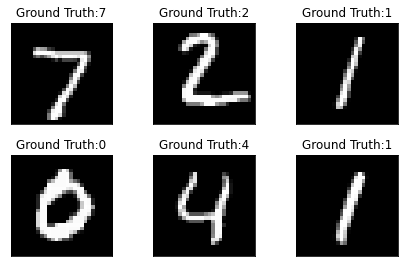

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx,(example_data,example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
class CNN(nn.Module):
    def __init__(self,in_dim,hidden_1,hidden_2,out_dim):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden_1, bias=True),nn.BatchNorm1d(hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(hidden_1,hidden_2,bias=True),nn.BatchNorm1d(hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(hidden_2,out_dim))
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
model = CNN(28*28,300,100,10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)


model_2 = CNN(28*28,300,100,10)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

In [ ]:
losses = []
acces = []

eval_losses = []
eval_acces = []

for epoch in range(nums_epoches):

    train_loss = 0
    train_acc = 0

    model.train()

    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img,label in train_loader:

        img = img.view(img.size(0),-1)
        
        out = model(img)

        loss = criterion(out,label)

        optimizer.zero_grad()
        loss.backward()
 
        optimizer.step()

        train_loss += loss.item()

        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses.append(train_loss/len(train_loader))
    acces.append(train_acc/len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    model.eval()
    for img,label in test_loader:
        img = img.view(img.size(0),-1)
        
        out = model(img)
        loss = criterion(out,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        eval_loss += loss.item()
        
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))

    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'
             .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),
                    eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch:0,Train Loss:0.3477,Train Acc:0.9175,Test Loss:0.1543,Test Acc:0.9530
epoch:1,Train Loss:0.1270,Train Acc:0.9652,Test Loss:0.1019,Test Acc:0.9669
epoch:2,Train Loss:0.0860,Train Acc:0.9765,Test Loss:0.0809,Test Acc:0.9744
epoch:3,Train Loss:0.0655,Train Acc:0.9822,Test Loss:0.0671,Test Acc:0.9797
epoch:4,Train Loss:0.0521,Train Acc:0.9862,Test Loss:0.0565,Test Acc:0.9834
epoch:5,Train Loss:0.0386,Train Acc:0.9905,Test Loss:0.0291,Test Acc:0.9920
epoch:6,Train Loss:0.0337,Train Acc:0.9923,Test Loss:0.0291,Test Acc:0.9919
epoch:7,Train Loss:0.0334,Train Acc:0.9922,Test Loss:0.0283,Test Acc:0.9919
epoch:8,Train Loss:0.0320,Train Acc:0.9927,Test Loss:0.0276,Test Acc:0.9923
epoch:9,Train Loss:0.0309,Train Acc:0.9933,Test Loss:0.0273,Test Acc:0.9925
epoch:10,Train Loss:0.0300,Train Acc:0.9937,Test Loss:0.0265,Test Acc:0.9938
epoch:11,Train Loss:0.0290,Train Acc:0.9940,Test Loss:0.0265,Test Acc:0.9938
epoch:12,Train Loss:0.0289,Train Acc:0.9940,Test Loss:0.0267,Test Acc:0.9934
epoch:13,

In [ ]:
losses_pgd = []
acces_pgd = []

eval_losses_pgd = []
eval_acces_pgd = []

for epoch in range(nums_epoches):

    train_loss = 0
    train_acc = 0

    model_2.train()

    if epoch%5 == 0:
        optimizer_2.param_groups[0]['lr'] *= 0.1
    for img,label in train_loader:

        img = img.view(img.size(0),-1)

        img_pgd = img + pgd(model_2, img, label, 1e-1, 1e-3, 1)
        
        out = model_2(img_pgd)

        loss = criterion_2(out,label)

        optimizer_2.zero_grad()
        loss.backward()
 
        optimizer_2.step()

        train_loss += loss.item()

        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses_pgd.append(train_loss/len(train_loader))
    acces_pgd.append(train_acc/len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    model_2.eval()
    for img,label in test_loader:
        img = img.view(img.size(0),-1)
        
        out = model_2(img)
        loss = criterion_2(out,label)
        
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
        
        eval_loss += loss.item()
        
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses_pgd.append(eval_loss/len(test_loader))
    eval_acces_pgd.append(eval_acc/len(test_loader))

    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'
             .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),
                    eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch:0,Train Loss:2.3178,Train Acc:0.1832,Test Loss:2.3168,Test Acc:0.1840
epoch:1,Train Loss:2.3179,Train Acc:0.1837,Test Loss:2.3177,Test Acc:0.1869
epoch:2,Train Loss:2.3177,Train Acc:0.1848,Test Loss:2.3194,Test Acc:0.1889
epoch:3,Train Loss:2.3176,Train Acc:0.1830,Test Loss:2.3195,Test Acc:0.1830
epoch:4,Train Loss:2.3171,Train Acc:0.1849,Test Loss:2.3176,Test Acc:0.1827
epoch:5,Train Loss:2.3174,Train Acc:0.1829,Test Loss:2.3141,Test Acc:0.1863
epoch:6,Train Loss:2.3184,Train Acc:0.1841,Test Loss:2.3190,Test Acc:0.1891
epoch:7,Train Loss:2.3181,Train Acc:0.1840,Test Loss:2.3163,Test Acc:0.1883
epoch:8,Train Loss:2.3176,Train Acc:0.1834,Test Loss:2.3182,Test Acc:0.1848
epoch:9,Train Loss:2.3174,Train Acc:0.1845,Test Loss:2.3195,Test Acc:0.1836
epoch:10,Train Loss:2.3176,Train Acc:0.1830,Test Loss:2.3158,Test Acc:0.1830
epoch:11,Train Loss:2.3176,Train Acc:0.1831,Test Loss:2.3172,Test Acc:0.1867
epoch:12,Train Loss:2.3181,Train Acc:0.1830,Test Loss:2.3186,Test Acc:0.1857
epoch:13,

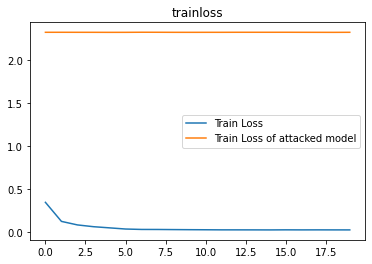

In [ ]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)),losses, np.arange(len(losses_pgd)),losses_pgd)
plt.legend(['Train Loss', 'Train Loss of attacked model'],loc='right')

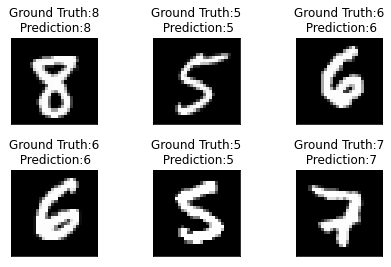

In [ ]:
%matplotlib inline
batch_idx,(example_data,example_targets) = next(examples)
fig = plt.figure()

img = example_data.view(example_data.size(0),-1)
label = example_targets
noise = pgd(model, img, label, 1, 1, 3)
img_pgd = img + noise
        
out = model(img)
_,pred = out.max(1)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}\n Prediction:{}".format(example_targets[i], pred[i]))
    plt.xticks([])
    plt.yticks([])

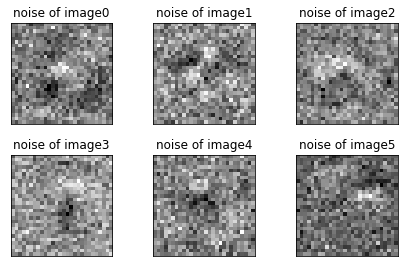

In [ ]:
%matplotlib inline
noise = noise.view(example_data.shape)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(noise[i][0],cmap='gray',interpolation='none')
    plt.title("noise of image{}".format(i))
    plt.xticks([])
    plt.yticks([])

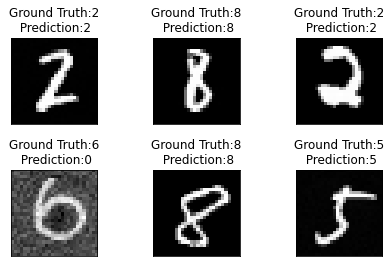

In [ ]:
%matplotlib inline

out_pgd = model(img_pgd)
_,pred_pgd = out_pgd.max(1)
example_pgd = img_pgd.view(example_data.shape)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_pgd[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}\n Prediction:{}".format(example_targets[i], pred_pgd[i]))
    plt.xticks([])
    plt.yticks([])